In [2]:
import pandas as pd

In [3]:
mimiciv_dir = './mimic_iv/'

In [4]:
# Import and explore datasets
diagnoses_icd = pd.read_csv(f'{mimiciv_dir}hosp/diagnoses_icd.csv', low_memory=False)
diagnoses_icd[:10]

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,11603789,25552978,3,65801,9
1,11603789,25552978,4,64881,9
2,11603789,25552978,5,V270,9
3,11603789,25552978,1,65221,9
4,11603789,25552978,2,64421,9
5,16809467,29803749,4,66982,9
6,16809467,29803749,1,64511,9
7,16809467,29803749,2,64811,9
8,16809467,29803749,5,V270,9
9,16809467,29803749,3,2449,9


In [5]:
# Import and explore datasets
d_icd_diagnoses = pd.read_csv(f'{mimiciv_dir}hosp/d_icd_diagnoses.csv', low_memory=False)
d_icd_diagnoses[:10]

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A
5,0022,9,Paratyphoid fever B
6,0023,9,Paratyphoid fever C
7,0029,9,"Paratyphoid fever, unspecified"
8,0030,9,Salmonella gastroenteritis
9,0031,9,Salmonella septicemia


In [12]:
# Filter patients with Dialysis
dialysis_codes = ["Z992", "N186", "5856", "V4511"]
diagnoses_icd["chronic_dialysis"] = diagnoses_icd["icd_code"].str.strip().isin(dialysis_codes)
diagnoses_icd.head()


,subject_id,hadm_id,seq_num,icd_code,icd_version,chronic_dialysis
0,11603789,25552978,3,65801,9,False
1,11603789,25552978,4,64881,9,False
2,11603789,25552978,5,V270,9,False
3,11603789,25552978,1,65221,9,False
4,11603789,25552978,2,64421,9,False


In [7]:
# Compare all patients with any Diagnosis code with the word 'dialysis' or 'end stage renal disease' 
# to codes specified by Eric
titles = []
for title in d_icd_diagnoses['long_title'].unique():
  if ("dialysis" in title.lower() or title.lower() == "end stage renal disease") and not "retin" in title.lower() and not "irido" in title.lower():
    titles.append(title)
    
dialysis_icds = d_icd_diagnoses[d_icd_diagnoses['long_title'].isin(titles)]

all_codes = dialysis_icds["icd_code"].to_numpy()
selected_codes = ["Z992", "N186", "5856", "V4511"]

total_selected_codes = diagnoses_icd["icd_code"].str.strip().isin(selected_codes).sum()
total_codes = diagnoses_icd["icd_code"].isin(all_codes).sum()
print("Number of diagnoses with Eric's codes:", total_selected_codes)
print("Number of diagnoses with ESRD / dialysis codes:", total_codes)
all_codes_diags = diagnoses_icd[diagnoses_icd["icd_code"].isin(all_codes)]
selected_codes_diags = diagnoses_icd[diagnoses_icd["icd_code"].str.strip().isin(selected_codes)]
total_patients = all_codes_diags["subject_id"].unique().shape[0]
total_selected_patients = selected_codes_diags["subject_id"].unique().shape[0]

print("Number of patients with Eric's codes:", total_selected_patients)
print("Number of patients with ESRD / dialysis codes:", total_patients)


Number of diagnoses with Eric's codes: 21649
Number of diagnoses with ESRD / dialysis codes: 24125
Number of patients with Eric's codes: 3576
Number of patients with ESRD / dialysis codes: 3672


In [49]:
# Examine codes common in patients that have ESRD / dialysis codes but not eric's codes
all_patients_ids = all_codes_diags["subject_id"].unique()
selected_patient_ids = selected_codes_diags["subject_id"].unique()
unselected_patient_ids = [id_num for id_num in all_patients_ids if not id_num in selected_patient_ids]
unselected_diags = diagnoses_icd[diagnoses_icd["subject_id"].isin(unselected_patient_ids)]
unselected_diags = unselected_diags[unselected_diags["icd_code"].isin(all_codes)]
unselected_diags["icd_code"].value_counts()

E8791      26
I953       25
99673      20
45821      16
T8249XA     5
V560        4
V561        3
Y841        2
Z9115       2
99656       1
T8242XA     1
T8241XA     1
T85621A     1
E8742       1
V4512       1
Name: icd_code, dtype: int64

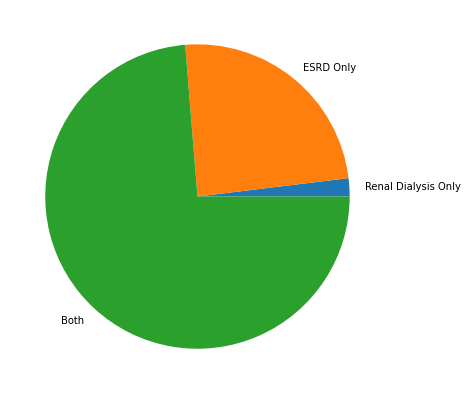

In [11]:
# Decided to use Eric's codes only based on feedback, Compare rates of ESRD vs dialysis vs both
from matplotlib import pyplot as plt

esrd_codes = ["N186", "5856"]
renal_dialysis_codes = ["V4511", "Z992"] 

esrd_diags = diagnoses_icd[diagnoses_icd["icd_code"].str.strip().isin(esrd_codes)]
num_esrd_patients = esrd_diags["subject_id"].unique().shape[0]

renal_dialysis_diags = diagnoses_icd[diagnoses_icd["icd_code"].str.strip().isin(renal_dialysis_codes)]
num_renal_dialysis_patients = renal_dialysis_diags["subject_id"].unique().shape[0]

num_both = num_renal_dialysis_patients + num_esrd_patients - total_selected_patients
num_renal_dialysis_only = num_renal_dialysis_patients - num_both
num_esrd_only = num_esrd_patients - num_both

  
# Creating dataset
labels = ["Renal Dialysis Only", "ESRD Only", "Both"]
  
data = [num_renal_dialysis_only, num_esrd_only, num_both]
  
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = labels)
  
# show plot
plt.show()